# Transfer Learning with VGG16 for Deep Space Object Classification





---


[**VGG16**](https://arxiv.org/pdf/1409.1556) is a convolutional neural network architecture with **16 layers** that are trainable (13 convolutional + 3 fully-connected). It was initially trained on the **[ImageNet](https://www.image-net.org/about.php)** dataset.


In Transfer Learning, we take these pre-trained weights, which learned general image features, and reuse them for a new classification task on our own dataset. This approach usually speeds up training and can improve accuracy when the new dataset is smaller or less diverse than ImageNet.

## 1. Add imports

We import **TensorFlow(2.18.0) / Keras** for building and training. We use **matplotlib** for plotting metrics and **numpy** for numerical operations. 'preprocess_input' from VGG16 is used later to normalize images.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os
print(tf.__version__)

2.18.0


# 3. Dataset

In this section, we will load our deep space objects dataset. It includes images from galaxies, nebulae, and star clusters. We will pull it from Google Drive, then split it into train, validation, and test sets. We will also apply basic preprocessing such as input resizing, normalization, etc.

## 3.1 Google Drive mounting


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.2 Data splitting for Training and Validation

We first split our main dataset into training and validation subsets. This is done using the `validation_split` parameter in `ImageDataGenerator`, where 20% of the images from the dataset are reserved for validation.

In [ ]:
dataset_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/DATA_split/train'
split_datagen = ImageDataGenerator(validation_split=0.2)

train_generator = split_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = split_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1213 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


## 3.3 Data Preprocessing

Next, we apply preprocessing to the images so they match what VGG16 expects. The `preprocessing_function` parameter of the `ImageDataGenerator` lets us use the VGG16-specific `preprocess_input` function. This step normalizes the image pixel values (e.g., scaling and mean subtraction) to be consistent with the data on which VGG16 was originally trained.

In [ ]:
test_dataset_dir = '/content/drive/MyDrive/Transfer Learning in Astronomy/DATA_split/test'

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=list(train_generator.class_indices.keys())
)


Found 265 images belonging to 3 classes.


# 4. Import VGG16 Model and Build the Classifier

## 4.1 Load and Inspect the VGG16 Architecture

`include_top=False` removes the default classifier, allowing us to add our own layers tailored to our classification task.

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Freeze the Pre-Trained Layers

freezing the layers ensures that the pre-trained feature extraction remains intact during initial training.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False


## 4.3 Build a New Classifier on Top

In [ ]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# 5. Train the Model

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1027s 27s/step - accuracy: 0.6801 - loss: 3.4707 - val_accuracy: 0.8704 - val_loss: 0.5862
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 975s 25s/step - accuracy: 0.9260 - loss: 0.3115 - val_accuracy: 0.8837 - val_loss: 0.4490
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 963s 25s/step - accuracy: 0.9639 - loss: 0.1360 - val_accuracy: 0.8837 - val_loss: 0.4974
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 955s 25s/step - accuracy: 0.9689 - loss: 0.0828 - val_accuracy: 0.9169 - val_loss: 0.5374
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 951s 25s/step - accuracy: 0.9814 - loss: 0.0394 - val_accuracy: 0.9003 - val_loss: 0.5183
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 963s 25s/step - accuracy: 0.9895 - loss: 0.0421 - val_accuracy: 0.9003 - val_loss: 0.5254
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 950s 25s/step - accuracy: 0.9847 - loss: 0.0325 - val_accuracy: 0.9103 - val_loss: 0.4737
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 950s 25s/step - accuracy: 0.9918 - loss: 0.0318 - val_accuracy: 0

# 6. Evaluate and Visualize the Model Performance

## 6.1 Plot Training Metrics

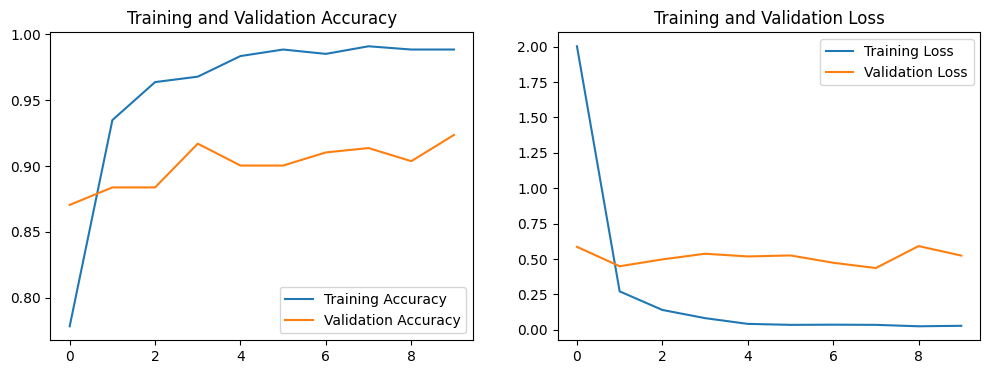

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


## 6.2 Final Evaluation on the Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 174s 19s/step - accuracy: 0.9273 - loss: 0.4142
Test Loss: 0.5379592180252075
Test Accuracy: 0.9018868207931519


# 7. Predict a Specific Image

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/Transfer Learning in Astronomy/images.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)  

predictions = model.predict(x)[0] 
predicted_class_index = np.argmax(predictions) 
predicted_probability = predictions[predicted_class_index] * 100  

class_indices = train_generator.class_indices 
idx_to_class = {v: k for k, v in class_indices.items()}  

predicted_class_name = idx_to_class[predicted_class_index]
print(f"Predicted Class: {predicted_class_name} ({predicted_probability:.2f}%)")

for class_idx, class_prob in enumerate(predictions):
    class_name = idx_to_class[class_idx]
    print(f"{class_name}: {class_prob:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Predicted Class: nebulae (100.00%)
clusters: 0.00%
galaxies: 0.00%
nebulae: 100.00%


# 8. Save the model

In [ ]:
model_save_path = "/content/drive/MyDrive/Transfer Learning in Astronomy/vgg.h5"

model.save(model_save_path)

print(f"Model saved successfully at: {model_save_path}")


Model saved successfully at: /content/drive/MyDrive/Transfer Learning in Astronomy/vgg.h5
